# 0. GETTING STARTED

In [64]:
!pip install rdkit
!pip install scaffoldgraph

'pip' is not recognized as an internal or external command,
operable program or batch file.
'pip' is not recognized as an internal or external command,
operable program or batch file.


In [65]:
from rdkit import Chem
from rdkit.Chem import Draw, PandasTools, AllChem, rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import base64
import matplotlib.pyplot as plt
from io import BytesIO
%matplotlib inline
import numpy as np
import seaborn as sn
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.metrics import r2_score
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from sklearn.inspection import permutation_importance
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scaffoldgraph as sg
import networkx as nx
from rdkit.Chem import Draw
from rdkit import Chem
import random
import os

In [56]:
#Morgan fingerprint

df_train = pd.read_csv('TrainQSAR.csv')
PandasTools.AddMoleculeColumnToFrame(df_train, 'SMILES', 'Molecule')

df_test = pd.read_csv('TestQSAR.csv')
PandasTools.AddMoleculeColumnToFrame(df_test, 'SMILES', 'Molecule')

def generate_fpts(data):
    Mfpts = []
    for mol in tqdm(data):
        mfpt = AllChem.GetMorganFingerprintAsBitVect(mol, 4, nBits=256)
        Mfpts.append(mfpt)

    return np.array(Mfpts)

mfpts_train = generate_fpts(df_train.Molecule)
mfpts_test = generate_fpts(df_test.Molecule)
morgan_train = pd.DataFrame(mfpts_train)
morgan_test = pd.DataFrame(mfpts_test)

100%|██████████| 329/329 [00:00<00:00, 5263.94it/s]


# 1. FIND OPTIMAL NUMBER OF CLUSTERS

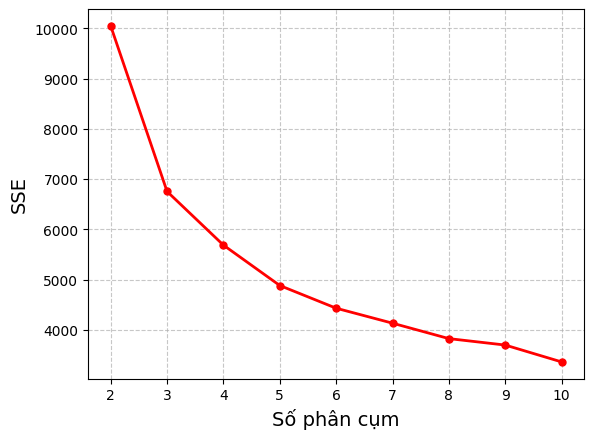

In [51]:
# Using jaccard value with elbow method

kmeans_kwargs = {
    "init": "random",
    "n_init": 20,
    "random_state": 78,
}

sse = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    distances = pairwise_distances(morgan_train.values, metric='jaccard')
    kmeans.fit(distances)
    sse.append(kmeans.inertia_)

plt.plot(range(2, 11), sse, marker = '.', markersize = 10, linewidth = 2, color = 'red',)
plt.xticks(range(2, 11))
plt.xlabel("Số phân cụm", fontsize = 14)
plt.ylabel("SSE", fontsize = 14)
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()

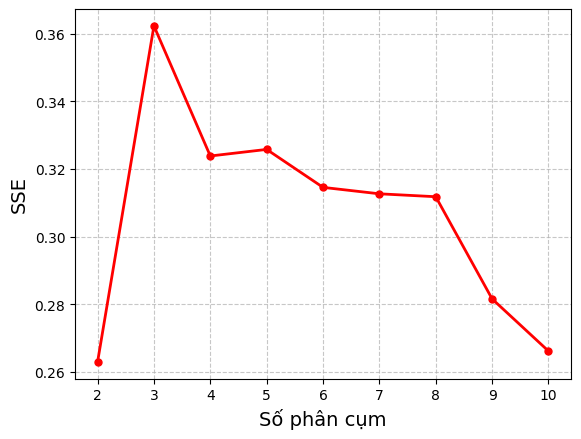

In [52]:
# Using jaccard value with silhouette score

kmeans_kwargs = {
    "init": "random",
    "n_init": 20,
    "random_state": 78,
}

silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    distances = pairwise_distances(morgan_train.values, metric='jaccard')
    kmeans.fit(distances)
    labels = kmeans.labels_
    score = silhouette_score(distances, labels)
    silhouette_scores.append(score)

plt.plot(range(2, 11), silhouette_scores, marker = '.', markersize = 10, linewidth = 2, color = 'red',)
plt.xticks(range(2, 11))
plt.xlabel("Số phân cụm", fontsize = 14)
plt.ylabel("SSE", fontsize = 14)
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()

In [58]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 20,
    "random_state": 78,
}

k = 3

kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
distances = pairwise_distances(morgan_train.values, metric='jaccard')
kmeans.fit(distances)
labels = kmeans.labels_

# 2. VISUALIZE CLUSTERS

In [59]:
X = morgan_train
tsne = TSNE(n_components=2, perplexity = 30.0, early_exaggeration=12.0, learning_rate=200, n_iter=1000,
            n_iter_without_progress=300,min_grad_norm=1e-07, metric='jaccard', random_state=42)
X_tsne = tsne.fit_transform(X)
tsne.kl_divergence_

0.5991470813751221

In [60]:
X_tsnefull = pd.DataFrame(X_tsne)
X_tsnefull['clusters'] = kmeans.labels_
tsne0 = X_tsnefull.loc[(X_tsnefull['clusters'] == 0)].copy()
tsne1 = X_tsnefull.loc[(X_tsnefull['clusters'] == 1)].copy()
tsne2 = X_tsnefull.loc[(X_tsnefull['clusters'] == 2)].copy()

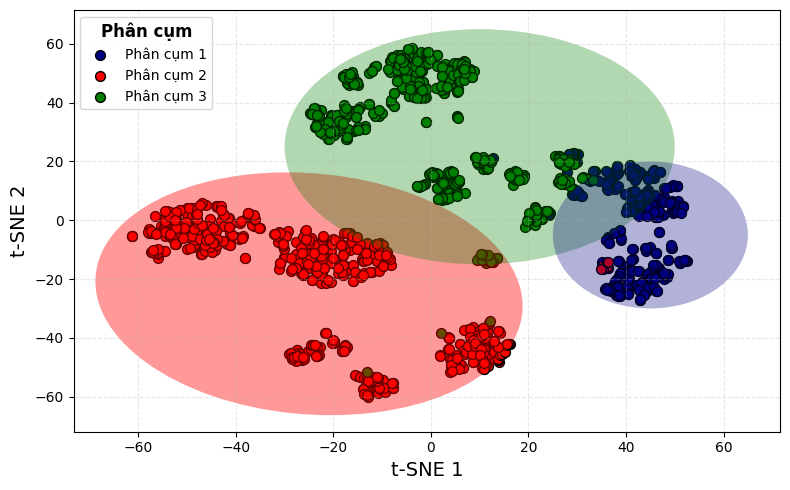

In [62]:
plt.figure(figsize=(8, 5))

data = [tsne0, tsne1, tsne2]
colors = ['navy', 'red', 'green']
labels = ['Phân cụm 1', 'Phân cụm 2', 'Phân cụm 3']

for i, d in enumerate(data):
    plt.scatter(d[0], d[1], color=colors[i], marker='o', s=50, label=labels[i], edgecolors='black')

plt.grid(axis='both', linestyle='--', alpha=0.3)


plt.xlabel("t-SNE 1", fontsize=14)
plt.ylabel("t-SNE 2", fontsize=14)

legend = plt.legend(title="Phân cụm", loc='upper left', fontsize=10)
plt.setp(legend.get_title(), fontsize=12, fontweight='bold')


u = -25   # x-position of the center
v = -25   # y-position of the center
a = 40     # radius on the x-axis
b = 45   # radius on the y-axis
angle = 60  # rotation angle in degrees
ellipse = patches.Ellipse((u, v), 2 * a, 2 * b, angle=angle, linewidth=2, fill=True, facecolor='red', alpha=0.4)
plt.gca().add_patch(ellipse)


u2 = 10   # x-position of the center for the second ellipse
v2 = 25  # y-position of the center for the second ellipse
a2 = 40   # radius on the x-axis for the second ellipse
b2 = 40     # radius on the y-axis for the second ellipse
angle2 = 0 # rotation angle in degrees for the second ellipse

ellipse2 = patches.Ellipse((u2, v2), 2 * a2, 2 * b2, angle=angle2, linewidth=2, fill=True, facecolor='green', alpha=0.3)

# Add the second ellipse to the plot
plt.gca().add_patch(ellipse2)

u3 = 45   # x-position of the center for the third ellipse
v3 = -5  # y-position of the center for the third ellipse
a3 = 20   # radius on the x-axis for the third ellipse
b3 = 25    # radius on the y-axis for the third ellipse
angle3 = 0 # rotation angle in degrees for the third ellipse

ellipse3 = patches.Ellipse((u3, v3), 2 * a3, 2 * b3, angle=angle3, linewidth=2, fill=True, facecolor='navy', alpha=0.3)

# Add the second ellipse to the plot
plt.gca().add_patch(ellipse3)
# Adjust plot layout
plt.tight_layout()

# Show the plot
plt.show()